In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# string manipulation libs
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from apyori import apriori
import networkx as nx 

def preprocess_text(text: str, remove_stopwords: bool) -> str:
    """This function cleans the input text by
    - removing links
    - removing special chars
    - removing numbers
    - removing stopwords
    - transforming in lower case
    - removing excessive whitespaces
    Arguments:
        text (str): text to clean
        remove_stopwords (bool): remove stopwords or not
    Returns:
        str: cleaned text
    """
    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove numbers and special chars
    text = re.sub("[^A-Za-z]+", " ", text)
    # remove stopwords
    if remove_stopwords:
        # 1. creates tokens
        tokens = nltk.word_tokenize(text)
        # 2. checks if token is a stopword and removes it
        tokens = [w for w in tokens if not w.lower() in stopwords.words("english")]
        # 3. joins all tokens again
        text = " ".join(tokens)
    # returns cleaned text
    text = text.lower().strip()
    return text

# load the data 
df=pd.read_csv("../../data/01-modified-data/breakin_prediction.csv", encoding = "ISO-8859-1")
df['cleaned'] = df['text'].apply(lambda x: preprocess_text(x, remove_stopwords=True))
df=df[df["label"]==1]
df["cleaned"]=df["cleaned"].apply(word_tokenize)
df1 = df[['cleaned']]
df1 = df1.reset_index()
df1 = df1.drop(columns=['index'])
df1.head()

,cleaned
0,"[owner, vancouver, butcher, shop, calling, cit..."
1,"[chased, cars, followed, criminals, home, offi..."
2,"[came, home, literally, seconds, neighbors, go..."
3,"[parked, golden, gate, park, minutes, run, car..."
4,"[life, moderately, sized, badly, run, city, fu..."


In [9]:
df2= df1['cleaned'].to_list()

#df2 = df2.drop(columns=['index'])

           rhs        lhs      supp      conf  supp x conf       lift
0      [alarm]      [car]  0.037037  1.000000     0.037037   1.636364
1      [alarm]       [go]  0.037037  1.000000     0.037037  27.000000
2         [go]    [alarm]  0.037037  1.000000     0.037037  27.000000
3       [also]      [car]  0.037037  0.666667     0.024691   1.090909
4       [also]  [grabbed]  0.037037  0.666667     0.024691  12.000000
..         ...        ...       ...       ...          ...        ...
392     [tree]  [windows]  0.037037  1.000000     0.037037   6.750000
393  [windows]     [tree]  0.037037  0.250000     0.009259   6.750000
394      [two]  [windows]  0.037037  1.000000     0.037037   6.750000
395  [windows]      [two]  0.037037  0.250000     0.009259   6.750000
396     [work]   [window]  0.037037  0.666667     0.024691   2.117647

[397 rows x 6 columns]


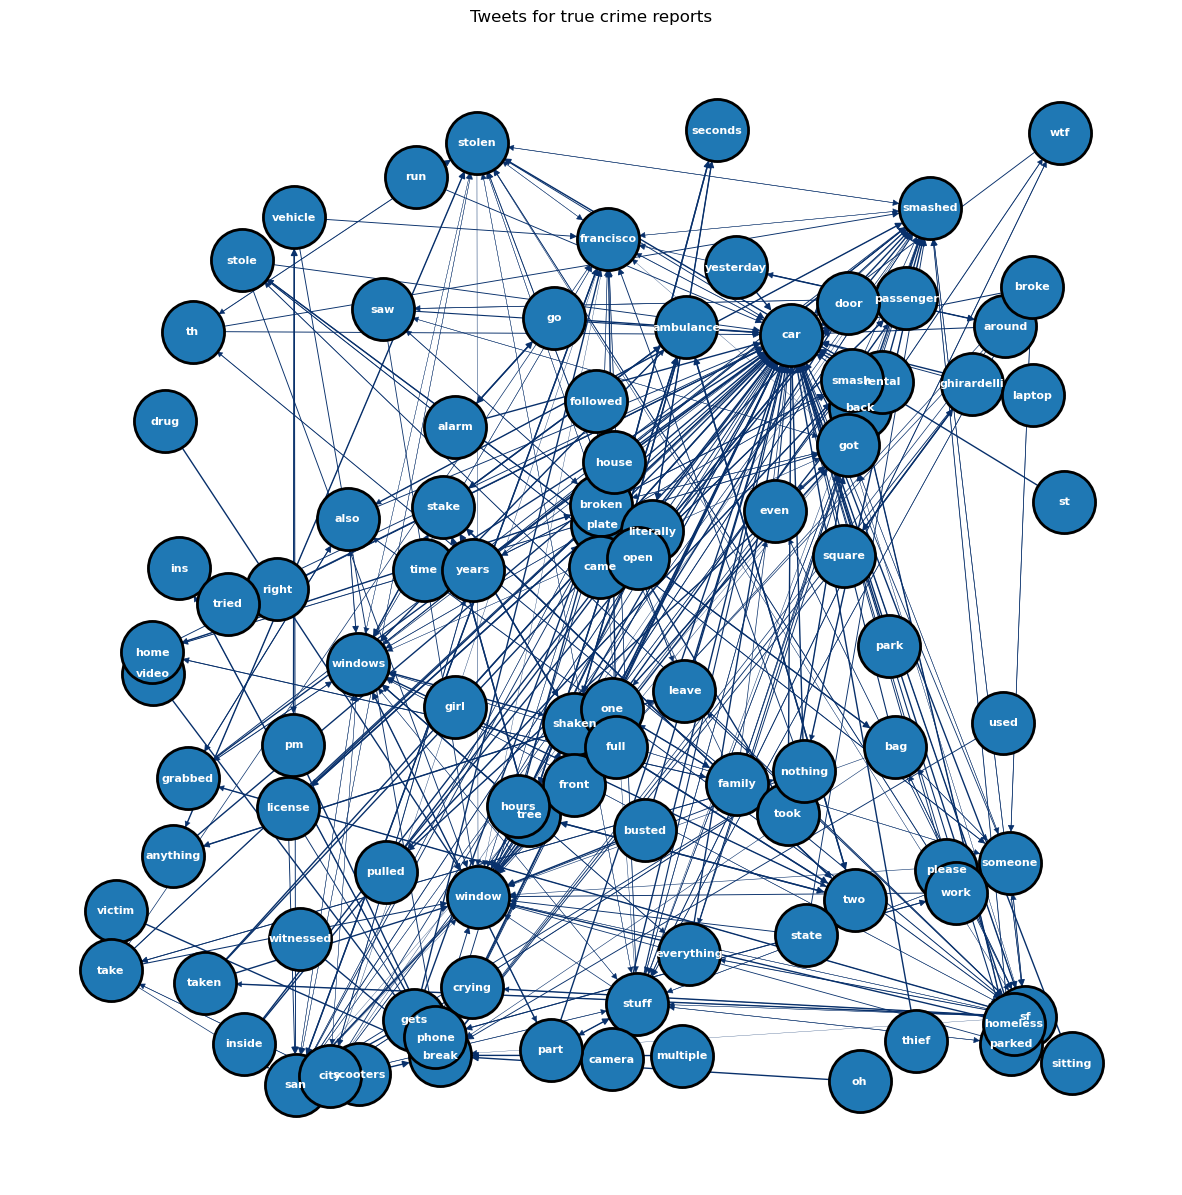

In [10]:
def reformat_results(results):
    keep =[]
    for i in range(0, len(results)):
        for j in range(0, len(list(results[i]))):
            if (j>1):
                for k in range(0, len(list(results[i][j]))):
                    if (len(results[i][j][k][0]) != 0):
                        rhs = list(results[i][j][k][0])
                        lhs = list(results[i][j][k][1])
                        conf = float(results[i][j][k][2])
                        lift = float(results[i][j][k][3])
                        keep.append([rhs,lhs,supp,conf,supp*conf,lift])
            if (j==1):
                supp = results[i][j]
    return pd.DataFrame(keep, columns =["rhs","lhs","supp","conf","supp x conf","lift"])

def convert_to_network(df):
    print(df)
    #BUILD GRAPH
    G = nx.DiGraph()  # DIRECTED
    for row in df.iterrows():
        # for column in df.columns:
        lhs="_".join(row[1][0])
        rhs="_".join(row[1][1])
        conf=row[1][3]; #print(conf)
        if(lhs not in G.nodes): 
            G.add_node(lhs)
        if(rhs not in G.nodes): 
            G.add_node(rhs)
        edge=(lhs,rhs)
        if edge not in G.edges:
            G.add_edge(lhs, rhs, weight=conf)
    return G

def plot_network(G):
    #SPECIFIY X-Y POSITIONS FOR PLOTTING
    pos=nx.random_layout(G)
    #GENERATE PLOT
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 15)
    #assign colors based on attributes
    weights_e 	= [G[u][v]['weight'] for u,v in G.edges()]
    #SAMPLE CMAP FOR COLORS 
    cmap=plt.cm.get_cmap('Blues')
    colors_e 	= [cmap(G[u][v]['weight']*10) for u,v in G.edges()]
    #PLOT
    nx.draw(
    G,
    edgecolors="black",
    edge_color=colors_e,
    node_size=2000,
    linewidths=2,
    font_size=8,
    font_color="white",
    font_weight="bold",
    width=weights_e,
    with_labels=True,
    pos=pos,
    ax=ax
    )
    ax.set(title='Tweets for true crime reports')
    plt.show()



           rhs        lhs      supp      conf  supp x conf      lift
0       [also]  [smashed]  0.055556  1.000000     0.055556  3.857143
1    [smashed]     [also]  0.055556  0.214286     0.011905  3.857143
2     [around]      [car]  0.055556  0.750000     0.041667  1.227273
3        [bag]      [car]  0.074074  0.800000     0.059259  1.309091
4        [bag]       [sf]  0.055556  0.600000     0.033333  3.240000
..         ...        ...       ...       ...          ...       ...
109  [smashed]  [windows]  0.111111  0.428571     0.047619  2.892857
110  [windows]  [smashed]  0.111111  0.750000     0.083333  2.892857
111   [stolen]   [window]  0.055556  0.333333     0.018519  1.058824
112    [stuff]   [window]  0.055556  0.500000     0.027778  1.588235
113     [take]   [window]  0.055556  0.750000     0.041667  2.382353

[114 rows x 6 columns]


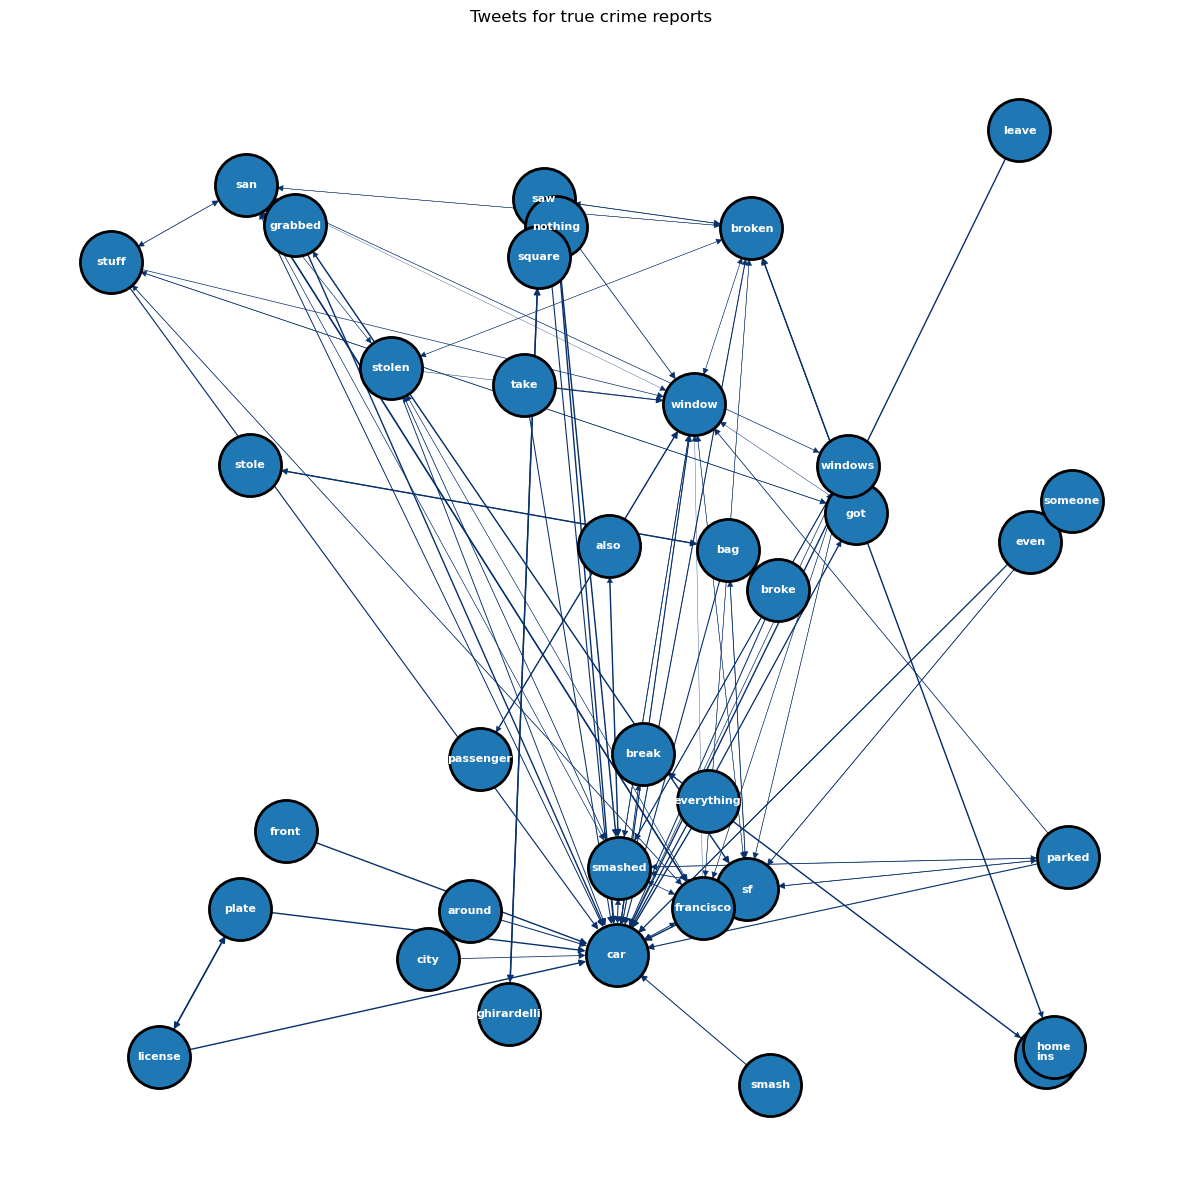

In [14]:
results = list(apriori(df2, min_support=0.05, min_confidence=0.2, min_length=3, max_length=2))
pd_results = reformat_results(results)
G = convert_to_network(pd_results)
plot_network(G)